<a href="https://colab.research.google.com/github/mint-aguccim/Machine_Learning_Programming/blob/main/9%EC%A3%BC%EC%B0%A8/%EA%B3%BC%EC%A0%9C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [33]:
# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1,1)
window = 12  # 시퀀스 윈도우 크기

In [34]:
# 2. Train / Test 데이터 분리 (스케일링 *전* 원본 데이터 기준)
split_point = int(len(data) * 0.8)
train_data = data[:split_point]
test_data = data[split_point:]

In [35]:
print(f"Original data points: {len(data)}")
print(f"Train data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")

Original data points: 325
Train data points: 260
Test data points: 65


In [36]:
# 3. 스케일링 (Data Leakage 방지)
scaler = MinMaxScaler()
# 3-1. scaler를 'train_data'에만 fit 합니다. (미래 정보(test)를 보지 않음)
scaler.fit(train_data)

MinMaxScaler()

In [37]:
# 3-2. fit된 scaler로 train과 test 데이터를 각각 'transform' 합니다.
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [38]:
# 4. 시퀀스 생성을 위한 함수 정의
def create_sequences(sequence, window):
    X, y = [], []
    # window 크기만큼의 여유가 필요하므로 (len(sequence) - window)
    for i in range(len(sequence) - window):
        X.append(sequence[i:i+window])
        y.append(sequence[i+window])
    return np.array(X), np.array(y)

In [39]:
# 5. Train/Test 시퀀스 데이터 생성
# 정규화된 train/test 데이터로 각각 X, y를 만듭니다.
X_train, y_train = create_sequences(train_scaled, window)
X_test, y_test = create_sequences(test_scaled, window)

In [40]:
print(f"\nTrain sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")


Train sequences: 248
Test sequences: 53


In [41]:
# -------------------------------------------------------------------
# 6. 모델 1: SimpleRNN
# -------------------------------------------------------------------
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
print("\n--- 1. SimpleRNN 모델 학습 시작 ---")
# 학습은 X_train, y_train으로만 수행합니다.
model_rnn.fit(X_train, y_train, epochs=50, batch_size=8,
              validation_data=(X_test, y_test), # 검증은 X_test, y_test로
              verbose=1)


--- 1. SimpleRNN 모델 학습 시작 ---
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1469 - val_loss: 0.0525
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0822
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0357
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - val_loss: 0.0506
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_loss: 0.0312
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0341
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0268
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0296
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 0.0594
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0270
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0184
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━

In [43]:
# -------------------------------------------------------------------
# 7. 모델 2: LSTM
# -------------------------------------------------------------------
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window,1)),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

In [44]:
print("\n--- 2. LSTM 모델 학습 시작 ---")
model_lstm.fit(X_train, y_train, epochs=50, batch_size=8,
               validation_data=(X_test, y_test),
               verbose=1)


--- 2. LSTM 모델 학습 시작 ---
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1076 - val_loss: 0.0585
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - val_loss: 0.0290
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112 - val_loss: 0.0284
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - val_loss: 0.0280
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0275
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - val_loss: 0.0276
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - val_loss: 0.0287
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093 - val_loss: 0.0271
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0096 - val_loss: 0.0297
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - val_loss: 0.0266
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0107 - val_loss: 0.0295
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s

In [45]:
# -------------------------------------------------------------------
# 8. 두 모델의 예측 수행 (Test 데이터 사용)
# -------------------------------------------------------------------
pred_rnn = model_rnn.predict(X_test)
pred_lstm = model_lstm.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [46]:
# 9. MSE / RMSE 계산 (성능 비교)
# 9-1. 원본 스케일로 복원 (scaler.inverse_transform 사용)
# y_test, pred_rnn, pred_lstm 모두 정규화(0~1)된 값이므로
# 원본 스케일로 되돌려야 올바른 MSE 비교가 가능합니다.
y_test_inv = scaler.inverse_transform(y_test)
pred_rnn_inv = scaler.inverse_transform(pred_rnn)
pred_lstm_inv = scaler.inverse_transform(pred_lstm)

In [47]:
# 9-2. 원본 스케일 MSE/RMSE 계산
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)

In [48]:
print("\n--- 3. 최종 모델 성능 비교 (Test Set / Original Scale) ---")
print(f"SimpleRNN - MSE: {mse_rnn:,.2f} / RMSE: {rmse_rnn:,.2f}")
print(f"LSTM      - MSE: {mse_lstm:,.2f} / RMSE: {rmse_lstm:,.2f}")


--- 3. 최종 모델 성능 비교 (Test Set / Original Scale) ---
SimpleRNN - MSE: 638,672.13 / RMSE: 799.17
LSTM      - MSE: 2,508,533.82 / RMSE: 1,583.84


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


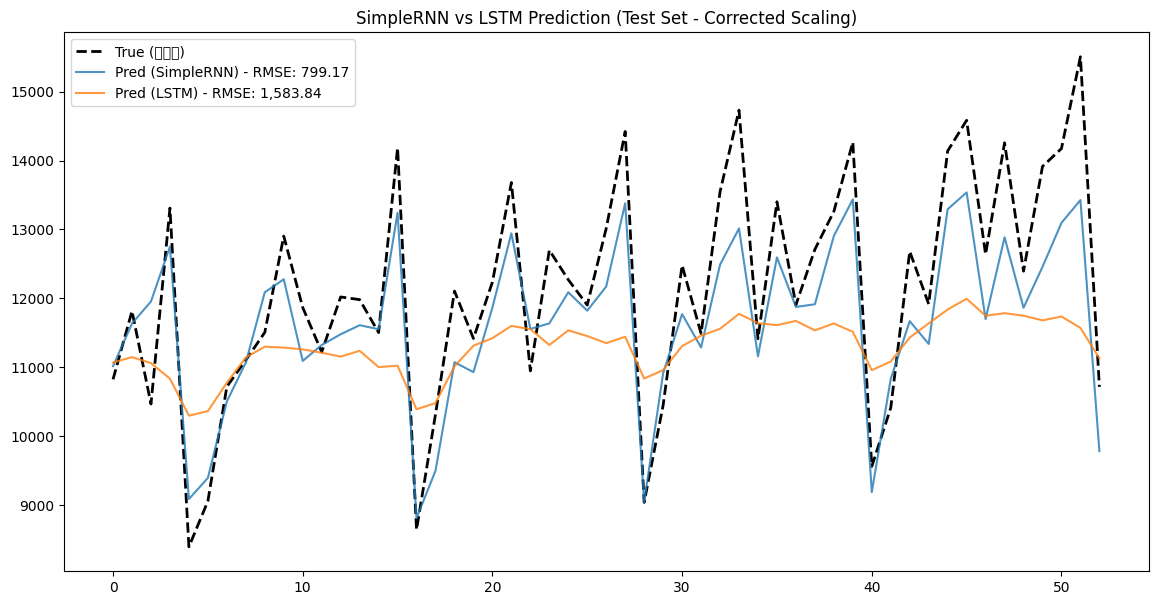

In [49]:
# 10. 시각화 (두 모델 비교)
plt.figure(figsize=(14, 7))
plt.title('SimpleRNN vs LSTM Prediction (Test Set - Corrected Scaling)')
plt.plot(y_test_inv, label='True (실제값)', color='black', linestyle='--', linewidth=2)
plt.plot(pred_rnn_inv, label=f'Pred (SimpleRNN) - RMSE: {rmse_rnn:,.2f}', alpha=0.8)
plt.plot(pred_lstm_inv, label=f'Pred (LSTM) - RMSE: {rmse_lstm:,.2f}', alpha=0.8)
plt.legend()
plt.show()